---
title: "Test 2: Recommender Systems"
subtitle: "Machine Learning III: Unsupervised and Network Analysis"
date: "9 April 2024"
author: 
  -  María del Valle Varo García


---
---

Yago Tobio Souto (201802168)

::: {.callout-important icon=false}

No puedes utilizar ChatGPT, pero tienes pleno acceso a Internet; no dudes en utilizarlo, ya que suele ser mucho más útil para programar, mirar documentación o resolver errores de código.
:::

::: {.callout-warning icon=false}

Evita dedicar tiempo a generar código o gráficas no solicitadas. 

No se evaluarán y sólo servirán para consumir tiempo del examen.
:::

---

In [1]:
# * Librerias
import os
import sys
import time
import math
import torch
import cornac
import warnings
import operator
import itertools
import scipy.stats
import numpy as np
import pandas as pd
import torch as torch
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
import scipy.sparse as sp
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data

from tabulate import tabulate
from cornac.utils import cache
from sklearn.manifold import TSNE
from adjustText import adjust_text
from collections import defaultdict
from scipy.sparse.linalg import svds
from torch.utils.data import Dataset
from numpy.linalg import matrix_rank
from cornac.datasets import movielens
from matplotlib.cbook import boxplot_stats
from cornac.eval_methods import RatioSplit

from sklearn.metrics import mean_squared_error
from elasticsearch import Elasticsearch, helpers
from sklearn.metrics.pairwise import cosine_similarity
from cornac.models import MF, NMF, BaselineOnly, BPR, WMF, UserKNN, ItemKNN, SVD

# **Análisis de ratings a Videojuegos**
### Utilizando la base de datos proporcionada que contiene información sobre usuarios, videojuegos y las calificaciones otorgadas por los usuarios a los videojuegos, realiza las siguientes tareas:




::: {.callout-tip icon="false}
### Question 0 (0.25 points)
Carga los datos como un objeto **panda.DataFrame**.
:::

In [2]:
# * Import file
df_path = "reduced_video_games.csv"
df = pd.read_csv(df_path, header=0)

In [3]:
# * - Preview, Resumen de caracteristicas, num filas x columns.
df.head()

,userId,productId,rating
0,A2BQXTSS8G6ZL2,B001TOQ8UW,5.0
1,AEJZHD61JTJKK,B0029LJIFG,5.0
2,A3TY2AEFHQRTWJ,B003O6E1JS,4.0
3,A8RITE7SJ9GYS,B0000E5U6I,3.0
4,A1SCCUZEPM657Y,B00DJFIMW6,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     250000 non-null  object 
 1   productId  250000 non-null  object 
 2   rating     250000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.7+ MB





::: {.callout-tip icon="false}
### Question 1 (0.75 points)
Filtra el conjunto de datos y conserva sólo los productos que hayan sido valorados al menos 20 veces.

:::

In [5]:
reviews_per_rating = df[["productId", "rating"]].value_counts()

select_product = (reviews_per_rating >= 20).groupby("productId").all()
select_product = select_product.index[select_product].to_list()

df_sample = df.loc[df["productId"].isin(select_product)]
df_sample.shape

(11405, 3)

In [6]:
df_sample.head()

,userId,productId,rating
4,A1SCCUZEPM657Y,B00DJFIMW6,5.0
50,A8WEWLW72ZF3S,B00DJFIMW6,5.0
116,A18PP6OEPTZRW9,B0015AARJI,5.0
119,AK9DKBNJ2Y98E,B0050SYLRK,5.0
120,A31HGROF3856IH,B00DJFIMW6,5.0


::: {.callout-tip icon="false}

### Question 2 (0.25 points)

¿Qué porcentaje de los datos (ya filtrados) tiene una calificación de 4 o superior?

:::

In [7]:
# ? - Hallar el número de ratings individuales - (Útil para observar proporción y escala de los ratings)
df_sample.value_counts("rating", normalize=True)*100

rating
5.0    49.636125
1.0    20.868040
4.0    15.046032
3.0     7.821131
2.0     6.628672
Name: proportion, dtype: float64

Una calificación de 4 o superior: 15.046 + 49.636 => 64,68%

::: {.callout-tip icon="false}
### Question 3 (0.25 points)

¿Cuántos usuarios únicos y productos hay?

:::

In [8]:
unique_number_users = df_sample["userId"].nunique()  # ? - Esto el número de valores únicos
unique_number_items = df_sample["productId"].nunique() # ? - El número de items unicos

print(f'Hay {unique_number_users} usuarios unicos y {unique_number_items} productos unicos.')

Hay 11331 usuarios unicos y 20 productos unicos.


::: {.callout-tip icon="false}
### Question 4 (0.25 points)

¿Qué porcentaje de valores atípicos hay?

:::

In [9]:
def explore_outliers(df, num_vars):
    """
    Explora y identifica los valores atípicos de variables numéricas en un DataFrame.

    Retorna:
    - outliers_df (diccionario): Diccionario con las variables numéricas como claves. Cada valor es otro diccionario
      con las claves 'values' (valores atípicos), 'positions' (posiciones de los valores atípicos en el DataFrame)
      e 'indices' (índices de los valores atípicos en el DataFrame).
    """
    outliers_df = dict()
    for k in range(len(num_vars)):
        var = num_vars[k]
        sns.boxplot(df, x=var)
        outliers_df[var] = boxplot_stats(df[var])[0][
            "fliers"
        ]  # ? - Boxplot de TODOS LOS RATINGS EN NUESTRA MUESTRA
        out_pos = np.where(df[var].isin(outliers_df[var]))[0].tolist()
        out_idx = [df[var].index.tolist()[k] for k in out_pos]
        outliers_df[var] = {
            "values": outliers_df[var],
            "positions": out_pos,
            "indices": out_idx,
        }
    return outliers_df

Percentage of outliers: 0.0 %


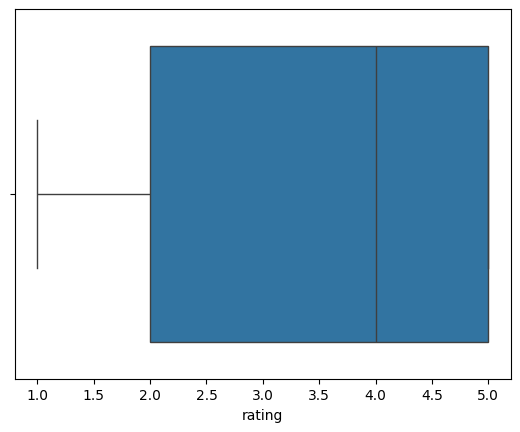

In [10]:
# * Obtener los outliers y visualizar el boxplot.
outlier_ratings = explore_outliers(df_sample, ["rating"])

# * Obtener porcentaje de outliers de nuestra muestra:
print(
    "Percentage of outliers:",
    round(len(outlier_ratings.get("rating").get("indices")) / len(df_sample), 3) * 100,
    "%",
)

No observamos ningún tipo de outliers en nuestro dataset para los 11400 ratings de los 20 productos.

::: {.callout-tip icon="false}
### Question 5 (1 points)

¿Cuál es la dispersión (sparsity) del conjunto de datos antes y después de filtrar los productos con más de 20 valoraciones? 

¿Es de esperar que los recomendadores memory-based funcionen mejor que los model-based conociendo ahora la dispersión?


:::

In [11]:
# * - Calculo de Sparsity. Nos dice si nuestro dataset exhibe propiedades long-tail
# * - Si el sparsity es alto, yo optaría por hacer Cosine similarity
# * - Como de llena esta nuestra matriz de ratings:
def print_sparsity(df):
    n_users = df.userId.nunique()
    n_items = df.productId.nunique()
    n_ratings = len(df)
    rating_matrix_size = n_users * n_items
    sparsity = 1 - n_ratings / rating_matrix_size

    print(f"Number of users: {n_users}")
    print(f"Number of items: {n_items}")
    print(f"Number of available ratings: {n_ratings}")
    print(f"Number of all possible ratings: {rating_matrix_size}")
    print("-" * 40)
    print(f"SPARSITY: {sparsity * 100.0:.2f}%")

In [12]:
print_sparsity(df)

Number of users: 206770
Number of items: 31263
Number of available ratings: 250000
Number of all possible ratings: 6464250510
----------------------------------------
SPARSITY: 100.00%


In [13]:
print_sparsity(df_sample)

Number of users: 11331
Number of items: 20
Number of available ratings: 11405
Number of all possible ratings: 226620
----------------------------------------
SPARSITY: 94.97%


> ¿Es de esperar que los recomendadores memory-based funcionen mejor que los model-based conociendo ahora la dispersión?

Los memory-based son aquellos modelos que utilizan el historial de ratings existentes para hacer nuestras predicciones. Visto a que la dispersión es muy alta, creo que los model-based funcionarán mejor, ya que utilizan SGD y son mejores a la hora de ubicar minimos optimos para una función de perdida cuyo objetivo es minimizar el error entre predicción y rating. Y el hecho que tambien lidian mejor con la reducción de dimensionalidad y vectores latentes para capturar información

In [14]:

# TODO - Verficar lo de ahí arriba 



::: {.callout-tip icon="false}
### Question 6 (0.75 points)

¿Cuál es el producto menos valorado? ¿Cuántas veces ha sido valorado?


:::

In [15]:
# Pseudo-code 
# * 1. Group by ProductId.
# * 2. Calculate the mean score for each one. 
# * 3. Descending order

In [16]:
grouped_df = df_sample.groupby("productId")
mean_rating = grouped_df["rating"].mean()
mean_rating_sorted = mean_rating.sort_values(ascending=False)
print(mean_rating_sorted)

productId
B00001OWYW    5.000000
B00DJFIMW6    4.465993
B0015AARJI    4.213510
B00FAX6XQC    4.212747
B009KS4XRO    4.062439
B0050SYLRK    3.972441
B003VANOFY    3.833333
B007XVTR3K    3.812680
B00CMQTVUA    3.710027
B003JVKHEQ    3.546185
B000ZKA0J6    3.451977
B00503E8S2    3.443038
B003JVCA9Q    3.429907
B002I098JE    3.364198
B00D4WTO1M    3.191083
B004FYEZMQ    2.935897
B0038TT8QM    2.630996
B00178630A    2.280543
B007VTVRFA    1.673171
B007FTE2VW    1.507692
Name: rating, dtype: float64


Worst valued product is B007FTE2VW  with a 1.507692 rating

In [17]:
df_sample[df_sample['productId']=='B007FTE2VW']

,userId,productId,rating
240,A34VG9L7Q2LAJC,B007FTE2VW,1.0
601,AOL67KOOTIOH7,B007FTE2VW,5.0
959,ALD2S6EQPXVOW,B007FTE2VW,1.0
986,A3OVC68J591A5X,B007FTE2VW,1.0
1078,A38UH2C2245BOL,B007FTE2VW,1.0
...,...,...,...
246859,A1ZLTZ3TLABKZ4,B007FTE2VW,1.0
248733,A3VY7IRWVB0Q1T,B007FTE2VW,2.0
248790,A2VEIH3QOGBNZR,B007FTE2VW,1.0
249224,A37BKSSW3B66W6,B007FTE2VW,3.0


It's been reviewed 520 times

::: {.callout-tip icon=true}

### Question 7 (0.75 points)

Haz un histograma de las valoraciones del segundo producto más valorado.

¿Cuál es la valoración media de este producto entre todos los usuarios?

:::

Segundo producto más valorado: B00DJFIMW6 with a 4.465993 rating

<Axes: xlabel='rating', ylabel='Count'>

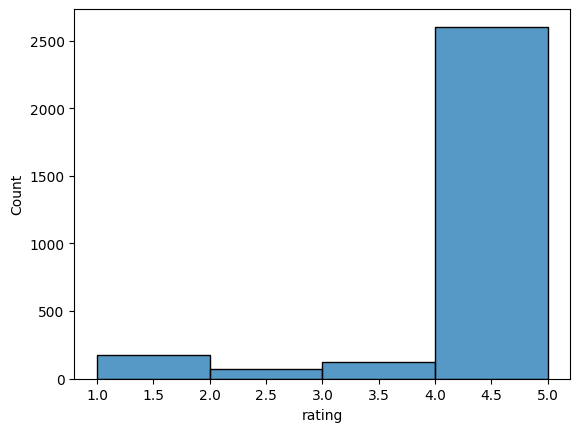

In [18]:
ratings_item_df = df_sample[df_sample['productId']=='B00DJFIMW6']
sns.histplot(
    x='rating', binwidth=1, data=ratings_item_df
)

Valoración media de este producto entre todos los usuarios:

In [19]:
ratings_item_df['rating'].mean()

4.465993265993266

::: {.callout-tip icon=true}

### Question 8 (1.0 points)

Haz varios sistemas de recomendación **User-Based** para este conjunto de datos para `k=30` vecinos.

Compara la similitud Pearson con la similitud Coseno. ¿Ayuda el centrado medio?

Comprueba diferentes métricas: RMSE, MAE, Precisión.
:::

In [20]:
# * Generar la matriz de ratings:
ratings_matrix = df_sample.pivot_table(
    index="userId",
    columns="productId",
    values="rating",
)

In [21]:
# * EDA de la matriz de ratings:
ratings_matrix.head()
df = ratings_matrix

In [22]:
df_sample

,userId,productId,rating
4,A1SCCUZEPM657Y,B00DJFIMW6,5.0
50,A8WEWLW72ZF3S,B00DJFIMW6,5.0
116,A18PP6OEPTZRW9,B0015AARJI,5.0
119,AK9DKBNJ2Y98E,B0050SYLRK,5.0
120,A31HGROF3856IH,B00DJFIMW6,5.0
...,...,...,...
249934,A3RCV194ARUXN4,B00DJFIMW6,1.0
249953,A2DTSKL59HVMN7,B007VTVRFA,1.0
249977,A2MPIDI0HTO26G,B00DJFIMW6,5.0
249985,A2WCSPJCI16S2F,B00503E8S2,2.0


In [23]:
df = df_sample.astype({"userId": object, "productId": object})
records = df.to_records(index=False)
result = list(records)
result

[('A1SCCUZEPM657Y', 'B00DJFIMW6', 5.),
 ('A8WEWLW72ZF3S', 'B00DJFIMW6', 5.),
 ('A18PP6OEPTZRW9', 'B0015AARJI', 5.),
 ('AK9DKBNJ2Y98E', 'B0050SYLRK', 5.),
 ('A31HGROF3856IH', 'B00DJFIMW6', 5.),
 ('AK0Y6OITL7VGX', 'B00178630A', 5.),
 ('AXRTGZFKSS8V8', 'B0015AARJI', 3.),
 ('A3BO7YGUVCYECE', 'B0050SYLRK', 5.),
 ('A3CG4J7Z8NKR84', 'B002I098JE', 5.),
 ('A34VG9L7Q2LAJC', 'B007FTE2VW', 1.),
 ('A10RYDD1VS68SR', 'B0015AARJI', 4.),
 ('A28P8GGF9NCT2Q', 'B002I098JE', 5.),
 ('A2PQAB4A5JHIFO', 'B003JVCA9Q', 5.),
 ('A13GTRM896G0OA', 'B00CMQTVUA', 1.),
 ('A3RB9AWS2AODHH', 'B00DJFIMW6', 5.),
 ('A28A45BUCXOKKY', 'B009KS4XRO', 5.),
 ('A84WOUN6A9UFX', 'B00CMQTVUA', 5.),
 ('A2FV22TBLETNGL', 'B0050SYLRK', 5.),
 ('A11XKLOG0T20IG', 'B00CMQTVUA', 1.),
 ('A6M6FIKSMXL8H', 'B00DJFIMW6', 5.),
 ('AULXRLXZ4F3ZU', 'B003VANOFY', 3.),
 ('AKYM3TP4HPIQU', 'B007VTVRFA', 1.),
 ('A2YOEMK6SV0BA1', 'B009KS4XRO', 5.),
 ('AOL67KOOTIOH7', 'B007FTE2VW', 5.),
 ('A247CWCB7EHRZK', 'B003JVCA9Q', 5.),
 ('A3JJIXLA0EG6HJ', 'B00DJFIMW6', 

In [24]:
ratio_split = RatioSplit(result, test_size=0.1, seed=42, verbose=2)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 10205
Number of items = 20
Number of ratings = 10264
Max rating = 5.0
Min rating = 1.0
Global mean = 3.7
---
Test data:
Number of users = 10205
Number of items = 20
Number of ratings = 14
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 10205
Total items = 20


In [25]:
# * Normalise the ratings matrix by subtracting every user's rating by the mean users rating:
normalized_ratings_matrix = ratings_matrix.subtract(ratings_matrix.mean(axis=1), axis=0)

# * Generación de modelos user-based con Pearson, Cosine y centrados
def userknn_cornac(df: pd.DataFrame):

    df = df.astype({"userId": object, "productId": object})
    records = df.to_records(index=False)
    result = list(records)

    K = 18 #! - Si te da error, baja el numero de k number of nearest neighbors
    VERBOSE = False
    SEED = 42
    uknn_cosine = UserKNN(
        k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
    )
    uknn_cosine_mc = UserKNN(
        k=K,
        similarity="cosine",
        mean_centered=True,
        name="UserKNN-Cosine-MC",
        verbose=VERBOSE,
    )
    uknn_pearson = UserKNN(
        k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
    )
    uknn_pearson_mc = UserKNN(
        k=K,
        similarity="pearson",
        mean_centered=True,
        name="UserKNN-Pearson-MC",
        verbose=VERBOSE,
    )

    # Metrics
    rec_300 = cornac.metrics.Recall(k=K)
    prec_30 = cornac.metrics.Precision(k=K)
    rmse = cornac.metrics.RMSE()
    mae = cornac.metrics.MAE()

    ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
    cornac.Experiment(
        eval_method=ratio_split,
        models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
        metrics=[rec_300, prec_30, rmse, mae],
    ).run()

    userknn_models = {
        "uknn_cosine": uknn_cosine,
        "uknn_cosine_mc": uknn_cosine_mc,
        "uknn_pearson": uknn_pearson,
        "uknn_pearson_mc": uknn_pearson_mc,
    }

    return userknn_models

In [26]:
userknn_models = userknn_cornac(df_sample)


TEST:
...
                   |    MAE |   RMSE | Precision@18 | Recall@18 | Train (s) | Test (s)
------------------ + ------ + ------ + ------------ + --------- + --------- + --------
UserKNN-Cosine     | 0.6905 | 0.6905 |       0.0397 |    0.7143 |    1.3217 |   0.0062
UserKNN-Cosine-MC  | 0.6667 | 0.6667 |       0.0397 |    0.7143 |    1.3085 |   0.0053
UserKNN-Pearson    | 0.6667 | 0.6667 |       0.0397 |    0.7143 |    1.2832 |   0.0055
UserKNN-Pearson-MC | 0.6667 | 0.6667 |       0.0397 |    0.7143 |    1.2797 |   0.0050



Como podemos observar todos los resultados son muy parecidos, el Mean Centered le ayuda al coseno, pero el mejor es el Pearson Mean-Centered. Observamos que los resultados de MAE, RMSE y Precision son todos muy parecidos

::: {.callout-tip icon=true}

### Question 9 (0.75 points)

Selecciona un usuario y recomiendale los 10 mejores productos basándote en el modelo de user-based que consideres oportuno dado el entrenamiento.

:::

In [27]:
def user_profiling(UID, model, user_df, TOPK=5):

    rating_mat = model.train_set.matrix

    UIDX = list(model.train_set.uid_map.items())[UID][0]

    print(f"userId = {UIDX}")
    print("-" * 35)
    print(user_df.loc[UIDX])

    ratings = pd.DataFrame(rating_mat.toarray())
    user_ratings = ratings.loc[UID]
    top_rated_items = np.argsort(user_ratings)[-TOPK:]
    print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
    print("-" * 35)
    print(user_df.iloc[top_rated_items.array])

In [28]:
df_user= pd.read_csv('reduced_video_games.csv').set_index("userId")
df_user.head()

,productId,rating
userId,,
A2BQXTSS8G6ZL2,B001TOQ8UW,5.0
AEJZHD61JTJKK,B0029LJIFG,5.0
A3TY2AEFHQRTWJ,B003O6E1JS,4.0
A8RITE7SJ9GYS,B0000E5U6I,3.0
A1SCCUZEPM657Y,B00DJFIMW6,5.0


In [29]:
model = userknn_models.get('uknn_pearson_mc')
top_rated_items = user_profiling(3, model, df_user, TOPK=10)

userId = A26OALL5BYR5UH
-----------------------------------
                 productId  rating
userId                            
A26OALL5BYR5UH  B003O6G6G4     5.0
A26OALL5BYR5UH  B00503E8S2     3.0

TOP 10 RATED ITEMS BY USER 3:
-----------------------------------
                 productId  rating
userId                            
A15T4950IAUFOK  B00005Q8LY     5.0
A11Y9FWLKIAO89  B008J16APQ     1.0
A2JZEIIOZJQ4P5  B000HZFCT2     5.0
A2LW5FCXSNY87R  B0007UQ0O8     1.0
A1SCCUZEPM657Y  B00DJFIMW6     5.0
A3TY2AEFHQRTWJ  B003O6E1JS     4.0
AEJZHD61JTJKK   B0029LJIFG     5.0
A21S5N7ZEU4QK9  B0016BVY7U     4.0
A1W269IB6MYVT8  B001IYR53W     5.0
A8RITE7SJ9GYS   B0000E5U6I     3.0


::: {.callout-tip icon=true}

### Question 10 (1.0 points)
Haz varios sistemas de recomendación **Item-based** para este conjunto de datos para `k=30` vecinos.

Compara la similitud Pearson, la similitud Coseno ajustado y la similitud Coseno. ¿Ayuda el centrado medio?

Comprueba diferentes métricas: RMSE, MAE, Precisión.
:::

In [30]:
def itemknn_cornac(df):
    df = df.astype({"userId": object, "productId": object})
    records = df.to_records(index=False)
    result = list(records)
    K = 18  # number of nearest neighbors
    VERBOSE = False
    SEED = 42
    iknn_cosine = ItemKNN(
        k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
    )
    iknn_cosine_mc = ItemKNN(
        k=K,
        similarity="cosine",
        mean_centered=True,
        name="ItemKNN-Cosine-MC",
        verbose=VERBOSE,
    )
    iknn_pearson = ItemKNN(
        k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
    )
    iknn_pearson_mc = ItemKNN(
        k=K,
        similarity="pearson",
        mean_centered=True,
        name="ItemKNN-Pearson-MC",
        verbose=VERBOSE,
    )

    # Metrics
    rmse = cornac.metrics.RMSE()
    mae = cornac.metrics.MAE()
    prec = cornac.metrics.Precision(k=K)
    ratio_split = RatioSplit(result, test_size=0.2, seed=SEED, verbose=VERBOSE)
    cornac.Experiment(
        eval_method=ratio_split,
        models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_cosine_mc],
        metrics=[rmse, mae, prec],
    ).run()
    itemknn_models = {
        "iknn_cosine": iknn_cosine,
        "iknn_pearson": iknn_pearson,
        "iknn_pearson_mc": iknn_pearson_mc,
        "iknn_cosine_mc": iknn_cosine_mc,
    }
    return itemknn_models

In [31]:
itemknn_models = itemknn_cornac(df_sample)


TEST:
...
                   |    MAE |   RMSE | Precision@18 | Train (s) | Test (s)
------------------ + ------ + ------ + ------------ + --------- + --------
ItemKNN-Cosine     | 0.6364 | 0.6364 |       0.0505 |    0.0592 |   0.0051
ItemKNN-Pearson    | 0.6364 | 0.6364 |       0.0505 |    0.0597 |   0.0049
ItemKNN-Pearson-MC | 0.6364 | 0.6364 |       0.0354 |    0.0599 |   0.0056
ItemKNN-Cosine-MC  | 0.6364 | 0.6364 |       0.0354 |    0.0593 |   0.0049



Todos los modelos parecen iguales, que raro, no? No ayuda mucho el centrado medio, que implica esto?

::: {.callout-tip icon=true}

### Question 11 (0.75 points)

Convierte la matriz de ratings pronosticadas en el entrenamiento de tu modelo **Item-Based** favorito en un objeto `pd.DataFrame`.
:::

In [32]:
model = itemknn_models.get('iknn_cosine_mc')
model = userknn_models.get('uknn_cosine')

In [33]:
predicted_ratings = pd.DataFrame(
    model.train_set.matrix.toarray(), 
    columns=list(model.train_set.iid_map.items()), 
    index=list(model.train_set.uid_map.items())
)

predicted_ratings.head()

,"(B000ZKA0J6, 0)","(B007VTVRFA, 1)","(B00DJFIMW6, 2)","(B00503E8S2, 3)","(B00178630A, 4)","(B003VANOFY, 5)","(B0050SYLRK, 6)","(B007FTE2VW, 7)","(B004FYEZMQ, 8)","(B00CMQTVUA, 9)","(B00FAX6XQC, 10)","(B0038TT8QM, 11)","(B00001OWYW, 12)","(B003JVCA9Q, 13)","(B00D4WTO1M, 14)","(B009KS4XRO, 15)","(B0015AARJI, 16)","(B003JVKHEQ, 17)","(B002I098JE, 18)","(B007XVTR3K, 19)"
"(A2YYMMJFEG3ZG1, 0)",5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A196G2C13JQ2EI, 1)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A418OINFE4WTM, 2)",0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A26OALL5BYR5UH, 3)",0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A33I59E9I8YHZK, 4)",0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


::: {.callout-tip icon=true}

### Question 12 (0.75 points)

¿Qué puntuación recibe el artículo `'B002I098JE` del usuario `'A7B5JEED0RKXG'` según este modelo?

¿Y según el model User-based?

:::

In [34]:
item_model = itemknn_models.get("iknn_cosine_mc")
item_mat_id = item_model.train_set.iid_map.get("B002I098JE")
user_mat_id = item_model.train_set.uid_map.get("A7B5JEED0RKXG")
# * Get the rating
item_model.score(user_mat_id, item_mat_id)

4.00000001

In [35]:
user_model = userknn_models.get("uknn_pearson_mc")
item_mat_id = user_model.train_set.iid_map.get("B002I098JE")
user_mat_id = user_model.train_set.uid_map.get("A7B5JEED0RKXG")
# * Get the rating
user_model.score(user_mat_id, item_mat_id)

4.00000001

::: {.callout-tip icon=true}

### Question 13 (1 points)

Haz un sistema de recomendación utilizando SVD para este dataset con k=100, otro para k=150 y otro para k=200. 

:::

In [36]:
# * - Función para generar el módelo SVD
def svd_cornac(
    df, k_min=100, k_max=250, step=50
):  # ! - Modificar dependiendo del dataset
    """
    Ejecuta experimentos SVD para un rango de valores de 'k' sobre un DataFrame utilizando Cornac.

    Devuelve:
    - (lista, cornac.Experiment): Lista de modelos SVD entrenados y el objeto experimento con los resultados.

    """
    df = df.astype({"userId": object, "productId": object})
    records = df.to_records(index=False)
    result = list(records)

    VERBOSE = False
    SEED = 42

    svd_models = []
    k_values = np.arange(k_min, k_max, step)
    for k in k_values:
        svd_models.append(
            SVD(
                name="SVD" + str(k),
                k=k,
                max_iter=30,
                learning_rate=0.01,
                lambda_reg=0.02,
                verbose=True,
            )
        )

    # Metrics
    rmse = cornac.metrics.RMSE()
    mae = cornac.metrics.MAE()

    ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
    svd_experiment = cornac.Experiment(
        eval_method=ratio_split,
        models=svd_models,
        show_validation=True,
        metrics=[rmse, mae],
    )
    svd_experiment.run()

    return svd_models, svd_experiment

In [37]:
svd_models, svd_experiment = svd_cornac(df_sample)

  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!

TEST:
...
       |    MAE |   RMSE | Train (s) | Test (s)
------ + ------ + ------ + --------- + --------
SVD100 | 1.0826 | 1.0826 |    0.0490 |   0.0017
SVD150 | 1.0957 | 1.0957 |    0.0612 |   0.0015
SVD200 | 1.0877 | 1.0877 |    0.0776 |   0.0019



::: {.callout-tip icon=true}

### Question 14 (0.75 points)

Selecciona uno de los modelos de SVD, elige a un usuario y recomiéndale 5 productos, luego imprime las puntuaciones que les otorgaría a esos productos.

:::

In [42]:
# * Función para recomendar a un usuario mediante el indice su producto
def recommend_products(index, model, data, num_products=5):

    print(
        "Name of Model:", model.name
    )  # ? - Sustituir el n, por el indice del modelo con menor RMSE

    # Rank all test items for a given user.
    df_rank = pd.DataFrame(
        {"ranked_items": model.rank(index)[0], "item_scores": model.rank(index)[1]},
        columns=["ranked_items", "item_scores"],
    )
    print(
        "Target UserId", df_sample.iloc[index].userId
    )  # * Cuidado aqui con el df_smaple

    df_rank.sort_values("item_scores", ascending=False, inplace=True)

    print(
        "Recommended products:",
        data.iloc[df_rank.head(num_products).ranked_items.values]["productId"].values,
    )
    print("Predicted scoreds: ", df_rank.head(num_products).item_scores.values)

In [43]:
recommend_products(1, svd_models[2], df_sample)

Name of Model: SVD200
Target UserId A8WEWLW72ZF3S
Recommended products: ['B00CMQTVUA' 'B00CMQTVUA' 'B002I098JE' 'B0050SYLRK' 'B002I098JE']
Predicted scoreds:  [4.7485533 4.2669916 4.0219693 3.9792528 3.9140017]
